About the dataset:

This dataset contains about 10 years of daily weather observations from different locations across Australia. Observations were drawn from numerous weather sources. predict whether or not it will rain the next day. There are 23 attributes including the target variable "RainTomorrow", indicating whether or not it will rain the next day or not.

# Importing Libraries

In [ ]:
import numpy as np 
import pandas as pd 

import os


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras import callbacks

np.random.seed(0)

# LOADING DATA

In [97]:
data = pd.read_csv(r"C:\Users\chapp\Downloads\weatherAUS.csv")
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,01-12-2008,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,02-12-2008,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,03-12-2008,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,04-12-2008,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,05-12-2008,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [98]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
Date             145460 non-null object
Location         145460 non-null object
MinTemp          143975 non-null float64
MaxTemp          144199 non-null float64
Rainfall         142199 non-null float64
Evaporation      82670 non-null float64
Sunshine         75625 non-null float64
WindGustDir      135134 non-null object
WindGustSpeed    135197 non-null float64
WindDir9am       134894 non-null object
WindDir3pm       141232 non-null object
WindSpeed9am     143693 non-null float64
WindSpeed3pm     142398 non-null float64
Humidity9am      142806 non-null float64
Humidity3pm      140953 non-null float64
Pressure9am      130395 non-null float64
Pressure3pm      130432 non-null float64
Cloud9am         89572 non-null float64
Cloud3pm         86102 non-null float64
Temp9am          143693 non-null float64
Temp3pm          141851 non-null float64
RainToday        142199 non-null obje

**Points to notice:**

* There are missing values in the dataset
* Dataset includes numeric and categorical values 


 
# DATA VISUALIZATION AND CLEANING

**Steps involves in this section:**

* Count plot of target column 
* Correlation amongst numeric attributes
* Parse Dates into datetime
* Encoding days and months as continuous cyclic features


<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

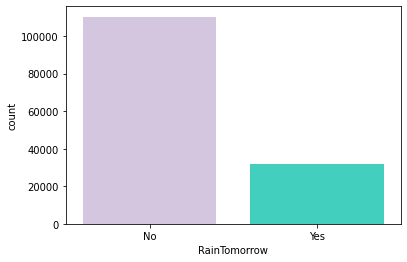

In [99]:
#evaluate the target and find out if the data is imbalanced or not
import seaborn as sns
cols= ["#d5c2e2","#2ce6d0"]
sns.countplot(x= data["RainTomorrow"], palette= cols)

In [ ]:
# Imbalanced data

<AxesSubplot:>

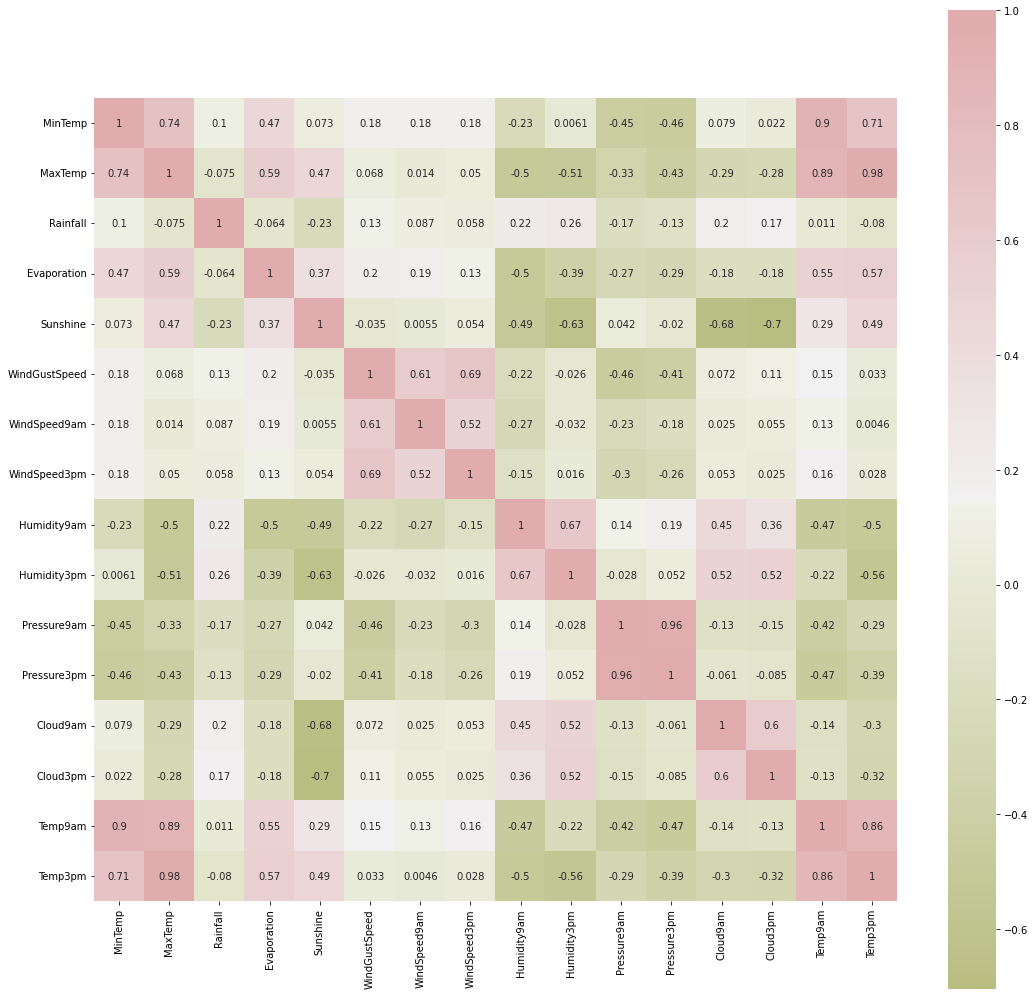

In [100]:
# Correlation among numeric attributes
corrmat = data.corr()
cmap = sns.diverging_palette(90,10,s=50, l=75, n=16, as_cmap=True)
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap= cmap,annot=True, square=True)

In [101]:
#Parsing datetime and exploring the length of date objects
lengths = data["Date"].str.len()
lengths.value_counts()

10    145460
Name: Date, dtype: int64

In [102]:
#There seem to be no error in dates so parsing values into datetime
data['Date']= pd.to_datetime(data["Date"])
#Creating a collumn of year
data['year'] = data.Date.dt.year

# function to encode datetime into cyclic parameters. 
# prefer the months and days in a cyclic continuous feature. 

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

data['month'] = data.Date.dt.month
data = encode(data, 'month', 12)

data['day'] = data.Date.dt.day
data = encode(data, 'day', 31)

data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-01-12,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,21.8,No,No,2008,1,0.500000,8.660254e-01,12,0.651372,-0.758758
1,2008-02-12,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,24.3,No,No,2008,2,0.866025,5.000000e-01,12,0.651372,-0.758758
2,2008-03-12,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,23.2,No,No,2008,3,1.000000,6.123234e-17,12,0.651372,-0.758758
3,2008-04-12,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,26.5,No,No,2008,4,0.866025,-5.000000e-01,12,0.651372,-0.758758
4,2008-05-12,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,29.7,No,No,2008,5,0.500000,-8.660254e-01,12,0.651372,-0.758758


Text(0.5, 0, 'Days In Year')

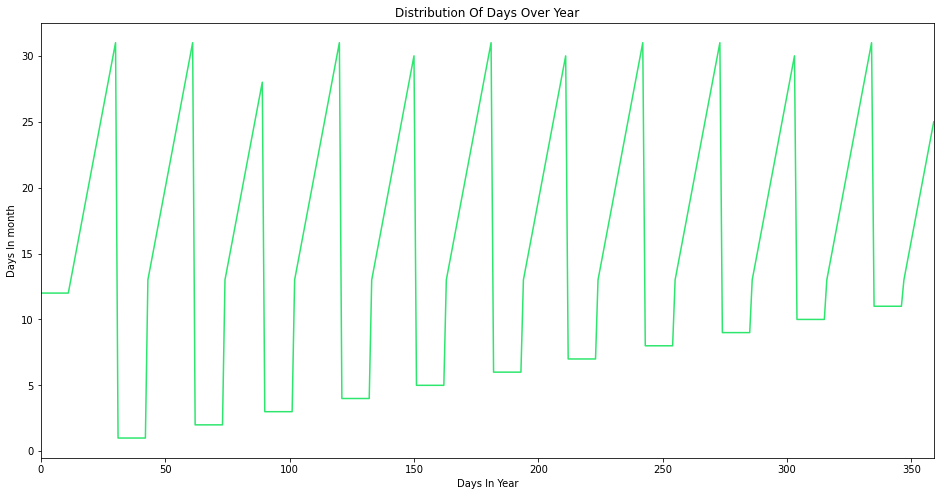

In [119]:
# roughly a year's span section 
section = data[:360] 
plt.figure(figsize=(16,8))
tm = section["day"].plot(color="#2ce66d")
tm.set_title("Distribution Of Days Over Year")
tm.set_ylabel("Days In month")
tm.set_xlabel("Days In Year")

The "year" attribute of data repeats. However in this for the true cyclic nature is not presented in a continuous manner. Splitting months and days into Sine and cosine combination provides the cyclical continuous feature. This can be used as input features to ANN. 

Text(0.5, 0, 'Sine Encoded Months')

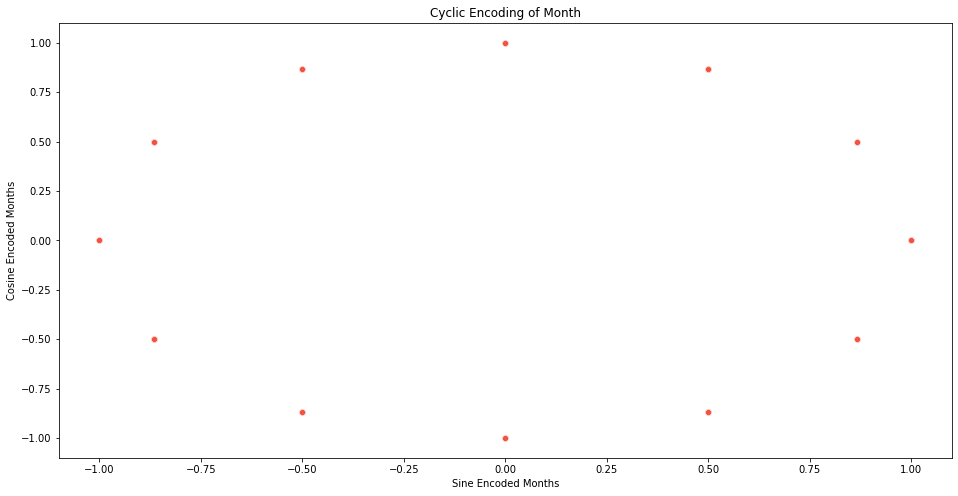

In [118]:
plt.figure(figsize=(16,8))
cyclic_month = sns.scatterplot(x="month_sin",y="month_cos",data=data, color="#f55142")
cyclic_month.set_title("Cyclic Encoding of Month")
cyclic_month.set_ylabel("Cosine Encoded Months")
cyclic_month.set_xlabel("Sine Encoded Months")


Text(0.5, 0, 'Sine Encoded Day')

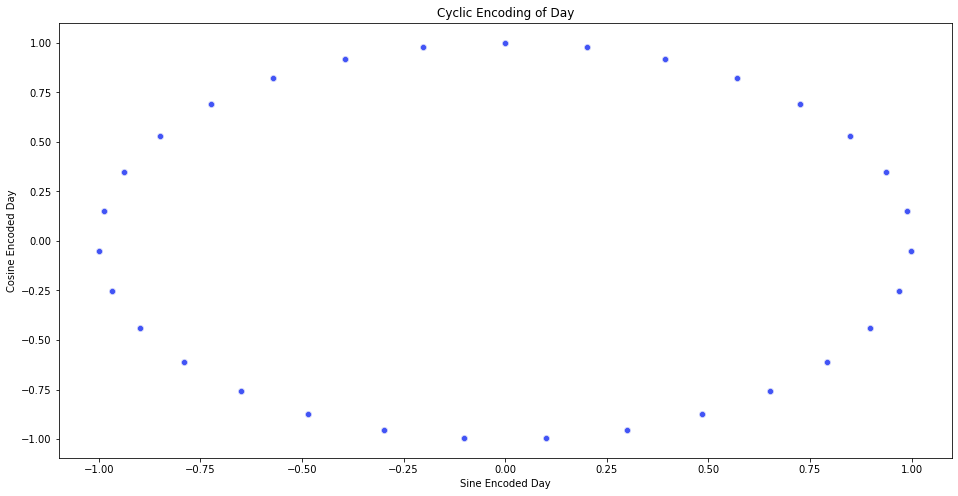

In [117]:
plt.figure(figsize=(16,8))
cyclic_day = sns.scatterplot(x='day_sin',y='day_cos',data=data, color="#4254f5")
cyclic_day.set_title("Cyclic Encoding of Day")
cyclic_day.set_ylabel("Cosine Encoded Day")
cyclic_day.set_xlabel("Sine Encoded Day")

 dealing with missing values in categorical and numeric attributes separately

**Categorical variables**

* Filling missing values with mode of the column value

In [106]:
# Get list of categorical variables
s = (data.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [107]:
# Missing values in categorical variables

for i in object_cols:
    print(i, data[i].isnull().sum())

Location 0
WindGustDir 10326
WindDir9am 10566
WindDir3pm 4228
RainToday 3261
RainTomorrow 3267


In [108]:
# Filling missing values with mode of the column in value

for i in object_cols:
    data[i].fillna(data[i].mode()[0], inplace=True)

**Numerical variables**

* Filling missing values with median of the column value

In [109]:
# Get list of neumeric variables
t = (data.dtypes == "float64")
num_cols = list(t[t].index)

print("Neumeric variables:")
print(num_cols)

Neumeric variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


In [110]:
# Missing values in numeric variables

for i in num_cols:
    print(i, data[i].isnull().sum())

MinTemp 1485
MaxTemp 1261
Rainfall 3261
Evaporation 62790
Sunshine 69835
WindGustSpeed 10263
WindSpeed9am 1767
WindSpeed3pm 3062
Humidity9am 2654
Humidity3pm 4507
Pressure9am 15065
Pressure3pm 15028
Cloud9am 55888
Cloud3pm 59358
Temp9am 1767
Temp3pm 3609
month_sin 0
month_cos 0
day_sin 0
day_cos 0


In [111]:
# Filling missing values with median of the column in value

for i in num_cols:
    data[i].fillna(data[i].median(), inplace=True)
    
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 30 columns):
Date             145460 non-null datetime64[ns]
Location         145460 non-null object
MinTemp          145460 non-null float64
MaxTemp          145460 non-null float64
Rainfall         145460 non-null float64
Evaporation      145460 non-null float64
Sunshine         145460 non-null float64
WindGustDir      145460 non-null object
WindGustSpeed    145460 non-null float64
WindDir9am       145460 non-null object
WindDir3pm       145460 non-null object
WindSpeed9am     145460 non-null float64
WindSpeed3pm     145460 non-null float64
Humidity9am      145460 non-null float64
Humidity3pm      145460 non-null float64
Pressure9am      145460 non-null float64
Pressure3pm      145460 non-null float64
Cloud9am         145460 non-null float64
Cloud3pm         145460 non-null float64
Temp9am          145460 non-null float64
Temp3pm          145460 non-null float64
RainToday        145460 n

Text(0.5, 0, 'Years')

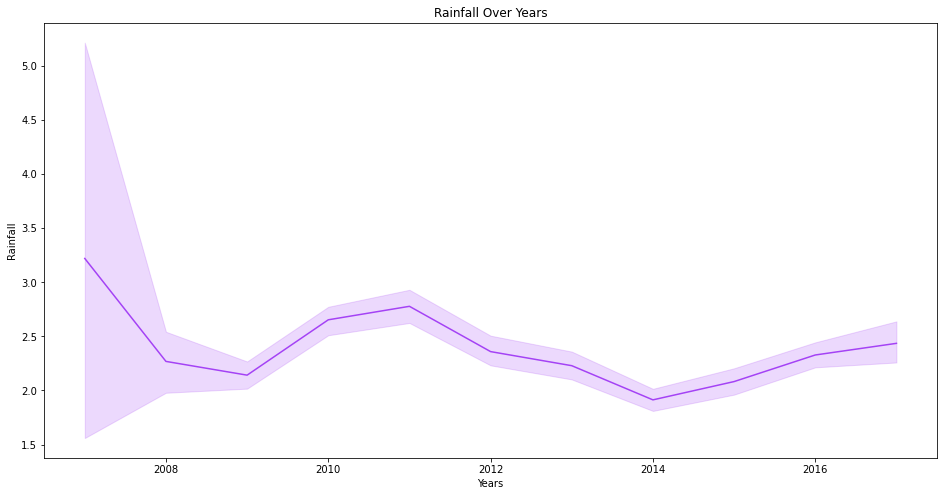

In [116]:
#plotting a lineplot rainfall over years
plt.figure(figsize=(16,8))
Time_series=sns.lineplot(x=data['Date'].dt.year,y="Rainfall",data=data,color="#a442f5")
Time_series.set_title("Rainfall Over Years")
Time_series.set_ylabel("Rainfall")
Time_series.set_xlabel("Years")

In [ ]:
#Evauating Wind gust speed over years
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(12,8))
Days_of_week=sns.barplot(x=data['Date'].dt.year,y="WindGustSpeed",data=data, ci =None,palette = colours)
Days_of_week.set_title("Wind Gust Speed Over Years")
Days_of_week.set_ylabel("WindGustSpeed")
Days_of_week.set_xlabel("Year")

# DATA PREPROCESSING

**Steps  in Data Preprocessing:**

* Label encoding columns with categorical data
* Perform the scaling of the features
* Detecting outliers
* Dropping the outliers based on data analysis

In [122]:
# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for i in object_cols:
    data[i] = label_encoder.fit_transform(data[i])
    
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 30 columns):
Date             145460 non-null datetime64[ns]
Location         145460 non-null int32
MinTemp          145460 non-null float64
MaxTemp          145460 non-null float64
Rainfall         145460 non-null float64
Evaporation      145460 non-null float64
Sunshine         145460 non-null float64
WindGustDir      145460 non-null int32
WindGustSpeed    145460 non-null float64
WindDir9am       145460 non-null int32
WindDir3pm       145460 non-null int32
WindSpeed9am     145460 non-null float64
WindSpeed3pm     145460 non-null float64
Humidity9am      145460 non-null float64
Humidity3pm      145460 non-null float64
Pressure9am      145460 non-null float64
Pressure3pm      145460 non-null float64
Cloud9am         145460 non-null float64
Cloud3pm         145460 non-null float64
Temp9am          145460 non-null float64
Temp3pm          145460 non-null float64
RainToday        145460 non-n

In [123]:
# Prepairing attributes of scale data

features = data.drop(['RainTomorrow', 'Date','day', 'month'], axis=1) # dropping target and extra columns

target = data['RainTomorrow']

#Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = preprocessing.StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names) 

features.describe().T

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,count,mean,std,min,25%,50%,75%,max
Location,145460.0,-5.633017e-14,1.000003,-1.672228,-0.899139,0.014511,0.857881,1.701250
MinTemp,145460.0,-4.243854e-15,1.000003,-3.250525,-0.705659,-0.030170,0.723865,3.410112
MaxTemp,145460.0,6.513740e-16,1.000003,-3.952405,-0.735852,-0.086898,0.703133,3.510563
Rainfall,145460.0,9.152711e-15,1.000003,-0.275097,-0.275097,-0.275097,-0.203581,43.945571
Evaporation,145460.0,1.352327e-14,1.000003,-1.629472,-0.371139,-0.119472,0.006361,43.985108
Sunshine,145460.0,-4.338304e-15,1.000003,-2.897217,0.076188,0.148710,0.257494,2.360634
WindGustDir,145460.0,1.864381e-14,1.000003,-1.724209,-0.872075,0.193094,1.045228,1.471296
WindGustSpeed,145460.0,-1.167921e-14,1.000003,-2.588407,-0.683048,-0.073333,0.460168,7.243246
WindDir9am,145460.0,-7.433272e-15,1.000003,-1.550000,-0.885669,0.000105,0.885879,1.771653
WindDir3pm,145460.0,1.791486e-15,1.000003,-1.718521,-0.837098,0.044324,0.925747,1.586813


In [ ]:
#Detecting outliers
#looking at the scaled features
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [124]:
#full data for 
features["RainTomorrow"] = target

#Dropping with outlier

features = features[(features["MinTemp"]<2.3)&(features["MinTemp"]>-2.3)]
features = features[(features["MaxTemp"]<2.3)&(features["MaxTemp"]>-2)]
features = features[(features["Rainfall"]<4.5)]
features = features[(features["Evaporation"]<2.8)]
features = features[(features["Sunshine"]<2.1)]
features = features[(features["WindGustSpeed"]<4)&(features["WindGustSpeed"]>-4)]
features = features[(features["WindSpeed9am"]<4)]
features = features[(features["WindSpeed3pm"]<2.5)]
features = features[(features["Humidity9am"]>-3)]
features = features[(features["Humidity3pm"]>-2.2)]
features = features[(features["Pressure9am"]< 2)&(features["Pressure9am"]>-2.7)]
features = features[(features["Pressure3pm"]< 2)&(features["Pressure3pm"]>-2.7)]
features = features[(features["Cloud9am"]<1.8)]
features = features[(features["Cloud3pm"]<2)]
features = features[(features["Temp9am"]<2.3)&(features["Temp9am"]>-2)]
features = features[(features["Temp3pm"]<2.3)&(features["Temp3pm"]>-2)]


features.shape

(127536, 27)

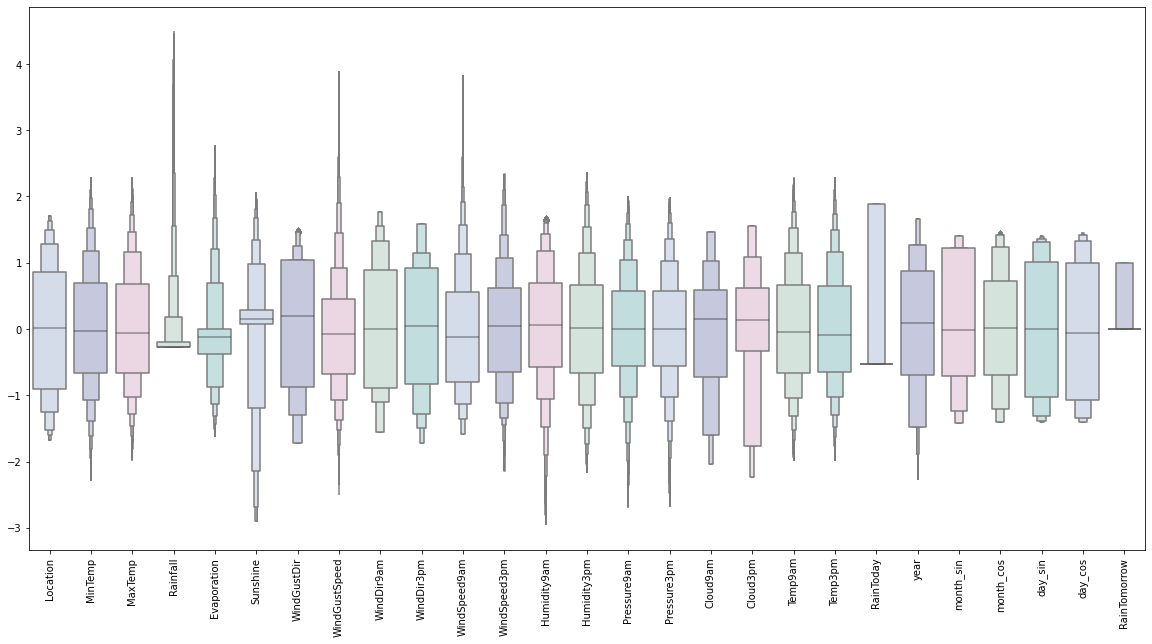

In [125]:
#looking at the scaled features without outliers

plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

Building artificial neural network.

 
# MODEL BUILDING

* Assining X and y the status of attributes and tags
* Splitting test and training sets
* Initialising the neural network
* Defining by adding layers
* Compiling the neural network
* Train the neural network

In [127]:
X = features.drop(["RainTomorrow"], axis=1)
y = features["RainTomorrow"]

# Splitting test, train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X.shape

(127536, 26)

In [128]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 26))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/150
2551/2551 [==============================] - 2s 800us/step - loss: 0.4789 - accuracy: 0.7841 - val_loss: 0.3945 - val_accuracy: 0.7860
Epoch 2/150
2551/2551 [==============================] - 2s 721us/step - loss: 0.4134 - accuracy: 0.7842 - val_loss: 0.3882 - val_accuracy: 0.7860
Epoch 3/150
2551/2551 [==============================] - 2s 719us/step - loss: 0.4099 - accuracy: 0.7842 - val_loss: 0.3853 - val_accuracy: 0.7860
Epoch 4/150
2551/2551 [==============================] - 2s 720us/step - loss: 0.4078 - accuracy: 0.7842 - val_loss: 0.3838 - val_accuracy: 0.7860
Epoch 5/150
2551/2551 [==============================] - 2s 725us/step - loss: 0.4063 - accuracy: 0.7842 - val_loss: 0.3822 - val_accuracy: 0.7860
Epoch 6/150
2551/2551 [==============================] - 2s 744us/step - loss: 0.4056 - accuracy: 0.8270 - val_loss: 0.3809 - val_accuracy: 0.8412
Epoch 7/150
2551/2551 [==============================] - 2s 751us/step - loss: 0.4056 - accuracy: 0.8355 - val_loss: 0

2551/2551 [==============================] - 2s 757us/step - loss: 0.3850 - accuracy: 0.8441 - val_loss: 0.3624 - val_accuracy: 0.8452
Epoch 57/150
2551/2551 [==============================] - 2s 783us/step - loss: 0.3841 - accuracy: 0.8438 - val_loss: 0.3624 - val_accuracy: 0.8446
Epoch 58/150
2551/2551 [==============================] - 2s 744us/step - loss: 0.3849 - accuracy: 0.8166 - val_loss: 0.3623 - val_accuracy: 0.8456
Epoch 59/150
2551/2551 [==============================] - 2s 721us/step - loss: 0.3839 - accuracy: 0.8166 - val_loss: 0.3621 - val_accuracy: 0.8464
Epoch 60/150
2551/2551 [==============================] - 2s 738us/step - loss: 0.3846 - accuracy: 0.8169 - val_loss: 0.3618 - val_accuracy: 0.8454
Epoch 61/150
2551/2551 [==============================] - 2s 738us/step - loss: 0.3832 - accuracy: 0.8164 - val_loss: 0.3620 - val_accuracy: 0.8454
Epoch 62/150
2551/2551 [==============================] - 2s 723us/step - loss: 0.3838 - accuracy: 0.8167 - val_loss: 0.3624 

Plotting training and validation loss over epochs

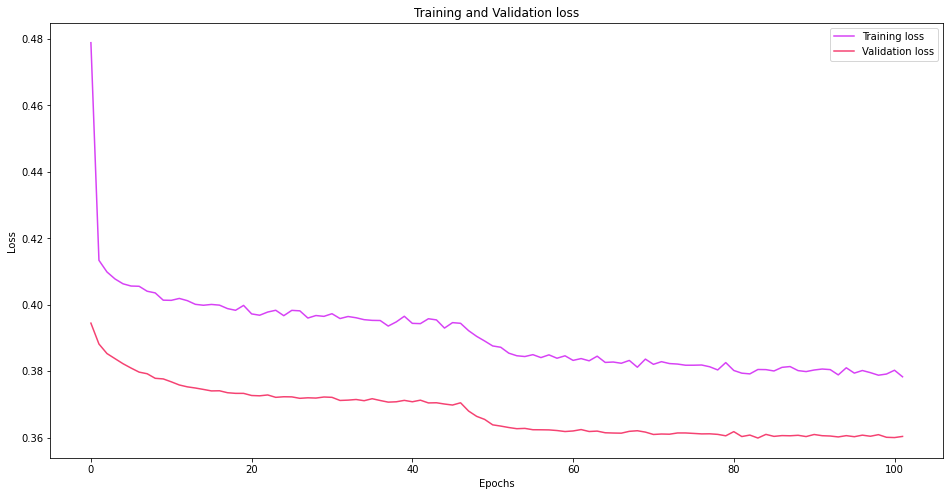

In [130]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(16,8))
plt.plot(history_df.loc[:, ['loss']], "#d742f5", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#f54272", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

Plotting training and validation accuracy over epochs

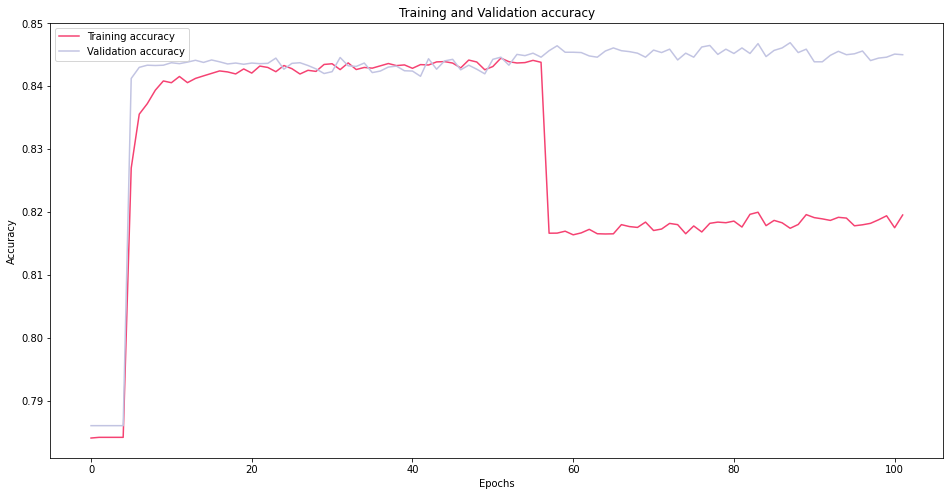

In [132]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(16,8))
plt.plot(history_df.loc[:, ['accuracy']], "#f54272", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


 
# CONCLUSIONS



* Testing on the test set
* Evaluating the confusion matrix
* Evaluating the classification report

In [133]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

<AxesSubplot:>

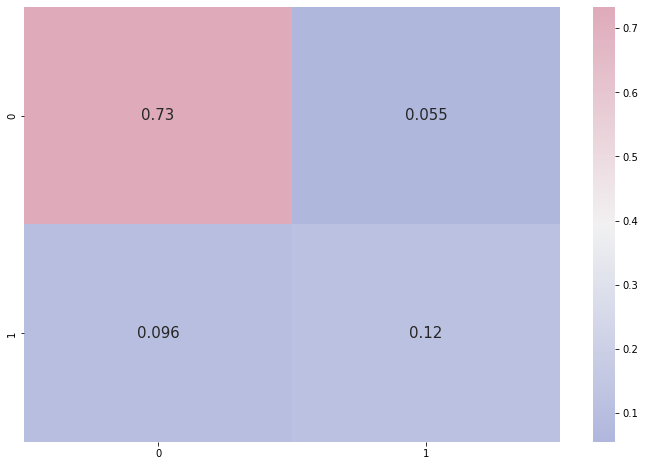

In [134]:
# confusion matrix
cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

In [135]:
#printing classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91     20110
           1       0.68      0.55      0.60      5398

   micro avg       0.85      0.85      0.85     25508
   macro avg       0.78      0.74      0.76     25508
weighted avg       0.84      0.85      0.84     25508

